<img align="left" src=https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=200 style="padding: 10px">
<br>
<b>AuxTel LATISS V&V Analysis Notebook</b> <br>
Contact author: Meredith Rawls<br>
Last verified to run: November 17, 2023<br>
LSST Science Piplines version: w_2023_46<br>
Container Size: Large <br>

# PREOPS-3603: Investigate lines of detections in Auxtel DIASources

Goal: Determine what was causing bogus lines of DiaSources in PREOPS-3429.

**Main takeaway:**

Most of the obviously bad DiaSources that fall in vertical lines seem to (nearly) all have the bad, interpolated, interpolatedCenter, and edge flags attached to them, as well as the shape flag. It is straightforward to filter the vast majority of garbage out by excluding sources that have one or more of these flags. In the future, some thought should be given to skipping over sources that are obviously garbage during difference imaging.

## Table of Contents

1. [Imports and setup](#section_1)
2. [Plot the problem](#section_2)
3. [Investigate flagged DiaSources](#section_3)
   
    3.1. [Side quest: schema changes](#section_3_1)

4. [Filter out flagged DiaSources](#section_4)


## 1. <a id="section_1">Imports and setup</a>

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

In [3]:
import lsst.daf.butler as dafButler
from lsst.pex.config import Config
from lsst.pipe.base import Instrument

In [4]:
import lsst.afw.display as afwDisplay
import lsst.display.astrowidgets
afwDisplay.setDefaultBackend('astrowidgets')
#afwDisplay.setDefaultBackend('matplotlib')

Per DM-39038, there are several LATISS collections with DIA data products

In [5]:
repo = '/sdf/group/rubin/repo/embargo'
skymapName = 'latiss_v1'
instrumentName = 'LATISS'
collection03B = 'u/huanlin/LATISS/runs/AUXTEL_DRP_IMAGING_2023-03B/w_2023_17/DM-39038/all'
collection05B = 'u/huanlin/LATISS/runs/AUXTEL_DRP_IMAGING_2023-05AB/w_2023_21/DM-39038'
collectionBig = 'u/huanlin/LATISS/runs/AUXTEL_DRP_IMAGING_2023-09A-08ABC-07AB-05AB/d_2023_09_25/DM-39038'
#collectionStr = collections.replace("/", "_")
butler03B = dafButler.Butler(repo, collections=collection03B, skymap=skymapName)
butler05B = dafButler.Butler(repo, collections=collection05B, skymap=skymapName)
butlerBig = dafButler.Butler(repo, collections=collectionBig, skymap=skymapName)

## 2. <a id="section_2">Plot the problem</a>

First, let's remind ourselves of the various DIA related data products that exist

In [6]:
print(butler03B.registry.queryDatasets('goodSeeingCoadd').count())
print(butler05B.registry.queryDatasets('goodSeeingCoadd').count())
print(butlerBig.registry.queryDatasets('goodSeeingCoadd').count())

631
107
297


In [7]:
print(butler03B.registry.queryDatasets('goodSeeingDiff_assocDiaSrcTable').count())
print(butler05B.registry.queryDatasets('goodSeeingDiff_assocDiaSrcTable').count())
print(butlerBig.registry.queryDatasets('goodSeeingDiff_assocDiaSrcTable').count())

203
35
95


In [8]:
print(butler03B.registry.queryDatasets('diaSourceTable').count())
print(butler05B.registry.queryDatasets('diaSourceTable').count())
print(butlerBig.registry.queryDatasets('diaSourceTable').count())

736
361
1585


In [9]:
visitList03B = []
for item in butler03B.registry.queryDatasets('diaSourceTable'):
    visitList03B.append(item.dataId.get('visit'))

visitList05B = []
for item in butler05B.registry.queryDatasets('diaSourceTable'):
    visitList05B.append(item.dataId.get('visit'))

visitListBig = []
for item in butlerBig.registry.queryDatasets('diaSourceTable'):
    visitListBig.append(item.dataId.get('visit'))

These visitLists will have the same lengths as the `diaSourceTable` queries immediately prior. Thereby justifying the name `butlerBig`!

To make life easier, let's make a little multi-visit plotting function

In [116]:
def multiVisitPlotter(butler, visitList, datasetType='diaSourceTable', badFlagList=None, printBadDiaSourceInfo=False):
    """Plot DiaSources from multiple visits.
    """
    for visit in visitList:
        try:
            oneDiaSourceTable = butler.get(datasetType, visit=visit)
        except LookupError:
            print(f'There is no visit {visit}, skipping it')
            continue
        else:
            # Deal with schema changes
            if 'filterName' in oneDiaSourceTable.columns:
                filterColumnName = 'filterName'
            else:
                filterColumnName = 'band'
            if 'decl' in oneDiaSourceTable.columns:
                decColumnName = 'decl'
            else:
                decColumnName = 'dec'
            
            if oneDiaSourceTable[filterColumnName][0] == 'g':
                color = 'C0'  # blue
            elif oneDiaSourceTable[filterColumnName][0] == 'r':
                color = 'C1'  # orange
            elif oneDiaSourceTable[filterColumnName][0] == 'i':
                color = 'C3'  # red
            else:
                color = '0.75'  # gray
            if badFlagList is None:  # ADDED LATER
                plt.scatter(oneDiaSourceTable.ra, oneDiaSourceTable[decColumnName], s=5, color=color)
                if printBadDiaSourceInfo:
                    print('Not filtering out any DiaSources; no badDiaSourceInfo to print')
            else:
                # Build up all the bad flags, e.g., (df['badflag1'] | df['badflag2'])
                conditionList = [oneDiaSourceTable[badFlag]==False for badFlag in badFlagList]
                bitwise_or_bad_flags = conditionList[0]
                for condition in conditionList:
                    bitwise_or_bad_flags |= condition
                bitwise_or_bad_flags.name = 'bitwise_or_bad_flags'
                if printBadDiaSourceInfo:
                    print(f'Visit {visit}: Ignoring {bitwise_or_bad_flags.value_counts().values[1]} bad DiaSources ({bitwise_or_bad_flags.value_counts().values[0]} DiaSources remain)')
                plt.scatter(oneDiaSourceTable.loc[bitwise_or_bad_flags, 'ra'],
                            oneDiaSourceTable.loc[bitwise_or_bad_flags, decColumnName],
                            s=5, color=color)
            plt.xlabel('RA (deg)')
            plt.ylabel('Dec (deg)')

Before we get too fancy, let's just look at how many fields are represented in these collections by naively plotting a sample of each

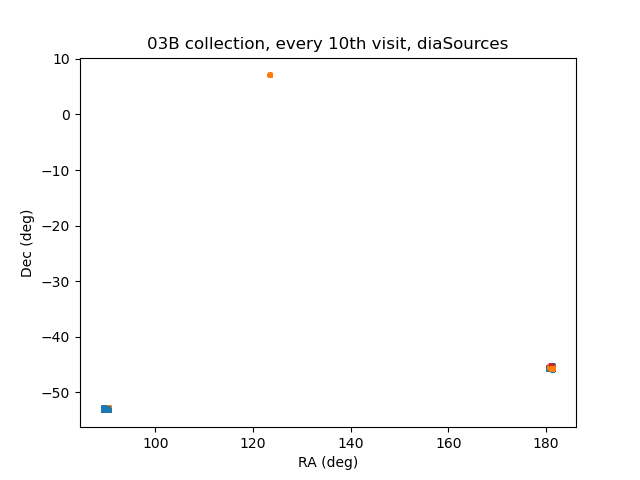

In [12]:
fig = plt.figure()
plt.title('03B collection, every 10th visit, diaSources')
multiVisitPlotter(butler03B, visitList03B[::10])  # the visit list is 700 long, so let's just plot every 10th visit for a quick look

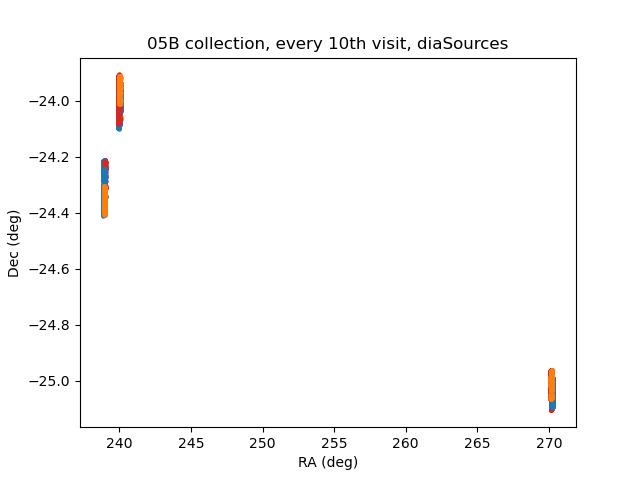

In [13]:
fig = plt.figure()
plt.title('05B collection, every 10th visit, diaSources')
multiVisitPlotter(butler05B, visitList05B[::10])

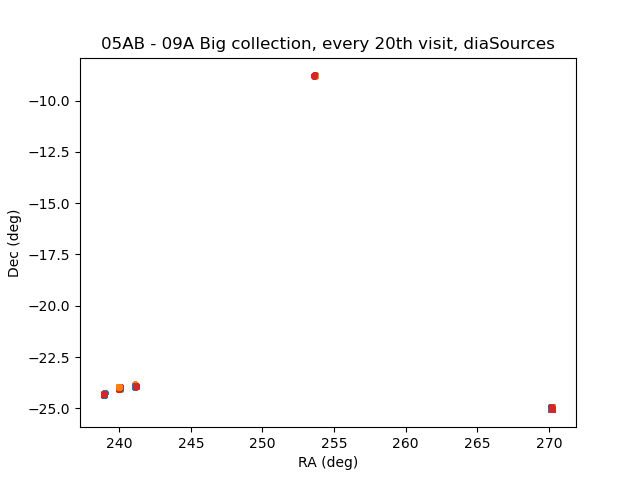

In [14]:
fig = plt.figure()
plt.title('05AB - 09A Big collection, every 20th visit, diaSources')
multiVisitPlotter(butlerBig, visitListBig[::20])

Let's examine three predefined spatial regions, since we're dealing with several fields here that span a big chunk of sky.
We're just going to compare the 05B and "Big" collections from here on out since the 03B one is pretty old.

In [22]:
def plotThreeSpatialRegions(butler, collection, visitList, badFlagList=None):
    """Loop over multiVisitPlotter, by default without filtering out any sources with bad flags.
    """

    fig = plt.figure(figsize=(9,7))
    fig.suptitle(f'DiaSources from {collection}', fontsize=10)
    
    ax1 = fig.add_subplot(221)
    ax1.set_xlim(239.1, 238.8)
    ax1.set_ylim(-24.425, -24.200)
    multiVisitPlotter(butler, visitList, badFlagList=badFlagList)
    
    ax2 = fig.add_subplot(222)
    ax2.set_xlim(240.15, 239.85)
    ax2.set_ylim(-24.15, -23.85)
    multiVisitPlotter(butler, visitList, badFlagList=badFlagList)
    
    ax3 = fig.add_subplot(223)
    ax3.set_xlim(270.35, 270.05)
    ax3.set_ylim(-25.12, -24.87)
    multiVisitPlotter(butler, visitList, badFlagList=badFlagList)

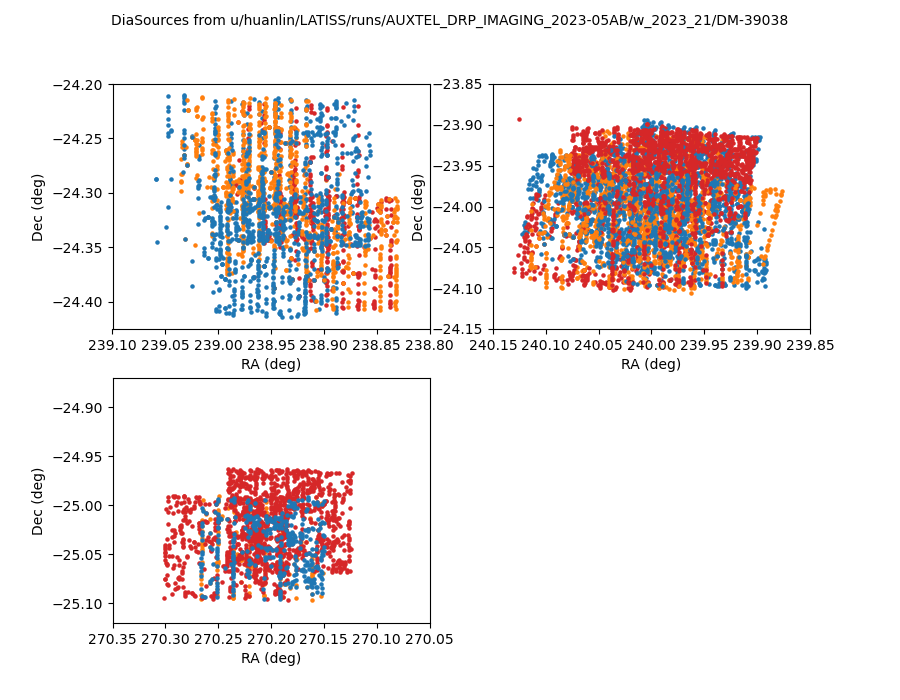

In [20]:
plotThreeSpatialRegions(butler05B, collection05B, visitList05B[0:50])

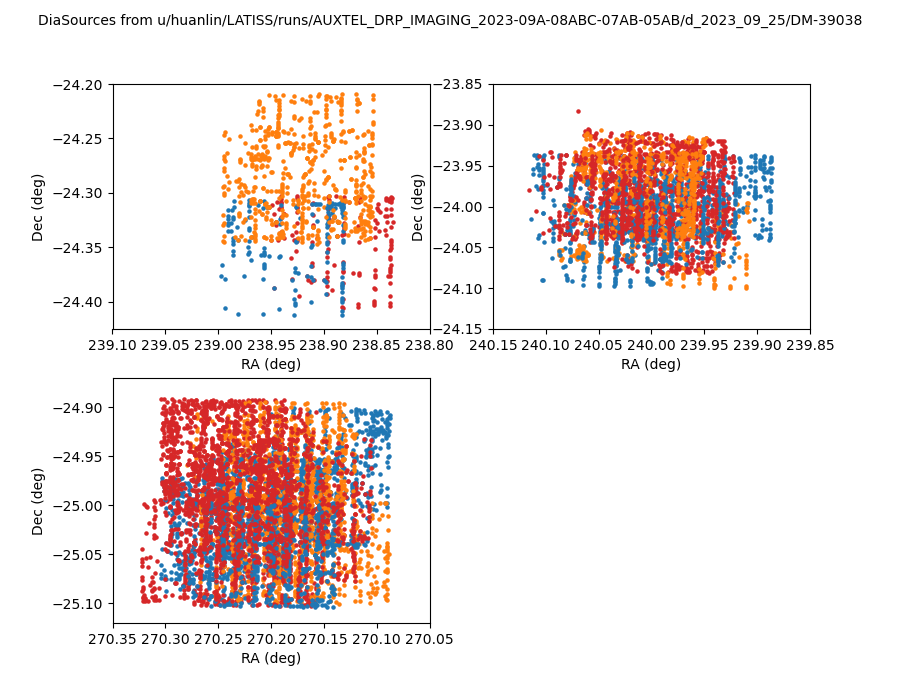

In [21]:
plotThreeSpatialRegions(butlerBig, collectionBig, visitListBig[0:50])

## 3. <a id="section_1">Investigate flagged DiaSources</a>

The problem didn't magically go away. But maybe the stripes are known bad sources?

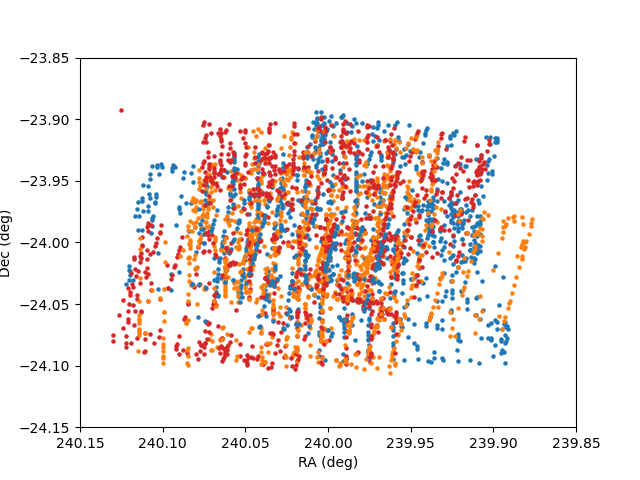

In [23]:
plt.figure()
ax = plt.gca()  # manually look at a region of sky with a handful of visits
ax.set_xlim(240.15, 239.85)
ax.set_ylim(-24.15, -23.85)
multiVisitPlotter(butler05B, visitList05B[0:30])

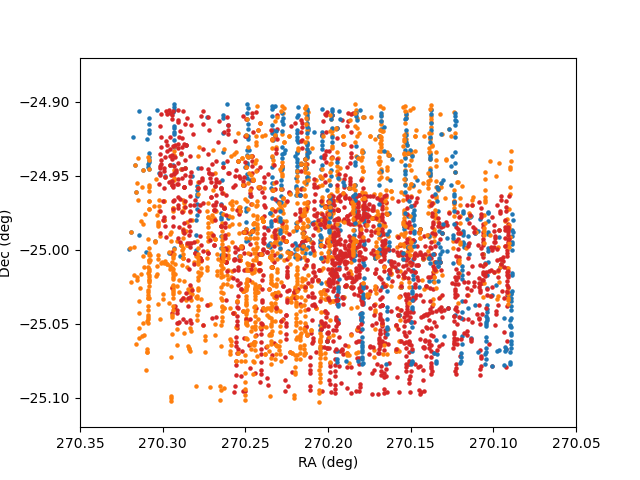

In [24]:
plt.figure()
ax = plt.gca()  # manually look at a region of the sky with a handful of visits
ax.set_xlim(270.35, 270.05)
ax.set_ylim(-25.12, -24.87)
multiVisitPlotter(butlerBig, visitListBig[1550:1580])

In [25]:
oneDiaSourceTable05B = butler05B.get('diaSourceTable', visit=visitList05B[0])
oneDiaSourceTableBig = butlerBig.get('diaSourceTable', visit=visitListBig[0])

### 3.1. <a id="section_3_1">Side quest: schema changes</a>

There have been some serious schema changes we need to get a handle on. Thankfully none of the flag names have changed...!

In [26]:
list(set(oneDiaSourceTable05B.columns) - set(oneDiaSourceTableBig.columns))  # columns in the old schema that aren't in the new schema

['dipLength',
 'psChi2',
 'psFlux',
 'spuriousness',
 'trailDecl',
 'dipAngle',
 'totFluxErr',
 'dipMeanFlux',
 'dipChi2',
 'dipMeanFluxErr',
 'decl',
 'psNdata',
 'filterName',
 'dipFluxDiffErr',
 'totFlux',
 'psFluxErr',
 'midPointTai',
 'dipFluxDiff']

In [27]:
list(set(oneDiaSourceTableBig.columns) - set(oneDiaSourceTable05B.columns))  # columns in the new schema that aren't in the old schema

['dipoleLength',
 'dec',
 'psfFluxErr',
 'time_processed',
 'dipoleMeanFlux',
 'scienceFlux',
 'ra_dec_Cov',
 'raErr',
 'scienceFluxErr',
 'dipoleFluxDiffErr',
 'reliability',
 'band',
 'psfChi2',
 'dipoleNdata',
 'dipoleFluxDiff',
 'midpointMjdTai',
 'dipoleMeanFluxErr',
 'trailDec',
 'psfFlux',
 'dipoleAngle',
 'psfNdata',
 'dipoleChi2',
 'decErr']

In [29]:
# manually assembled by looking at all the diaSourceTable columns and writing down the ones with "flag" or "Flags"
flagList = ['pixelFlags_offimage',
       'pixelFlags_edge', 'pixelFlags_interpolated', 'pixelFlags_saturated',
       'pixelFlags_cr', 'pixelFlags_bad', 'pixelFlags_suspect',
       'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter',
       'pixelFlags_crCenter', 'pixelFlags_suspectCenter', 'centroid_flag',
       'centroid_pos_flag', 'centroid_neg_flag', 'apFlux_flag',
       'apFlux_flag_apertureTruncated', 'psfFlux_flag',
       'psfFlux_flag_noGoodPixels', 'psfFlux_flag_edge', 'forced_PsfFlux_flag',
       'forced_PsfFlux_flag_noGoodPixels', 'forced_PsfFlux_flag_edge',
       'shape_flag', 'shape_flag_no_pixels', 'shape_flag_not_contained',
       'shape_flag_parent_source']

Text(0.5, 1.0, 'u/huanlin/LATISS/runs/AUXTEL_DRP_IMAGING_2023-05AB/w_2023_21/DM-39038')

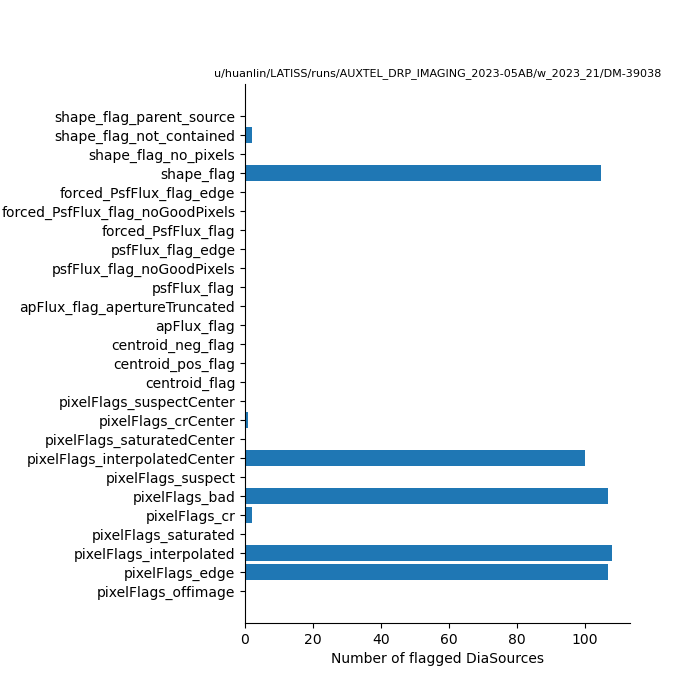

In [33]:
oneFlagTable = oneDiaSourceTable05B[flagList]
oneFlagLabels = oneFlagTable.columns
oneFlagSum = oneFlagTable.sum()
oneFlagsToPlot = [count for count in oneFlagSum.values]

fig, ax = plt.subplots(figsize=(7, 7))
ax.barh(oneFlagLabels, oneFlagsToPlot)#, color=flagColors)
fig.subplots_adjust(left=0.35)
ax.set_xlabel('Number of flagged DiaSources')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title(collection05B, fontsize=8)

Text(0.5, 1.0, 'u/huanlin/LATISS/runs/AUXTEL_DRP_IMAGING_2023-09A-08ABC-07AB-05AB/d_2023_09_25/DM-39038')

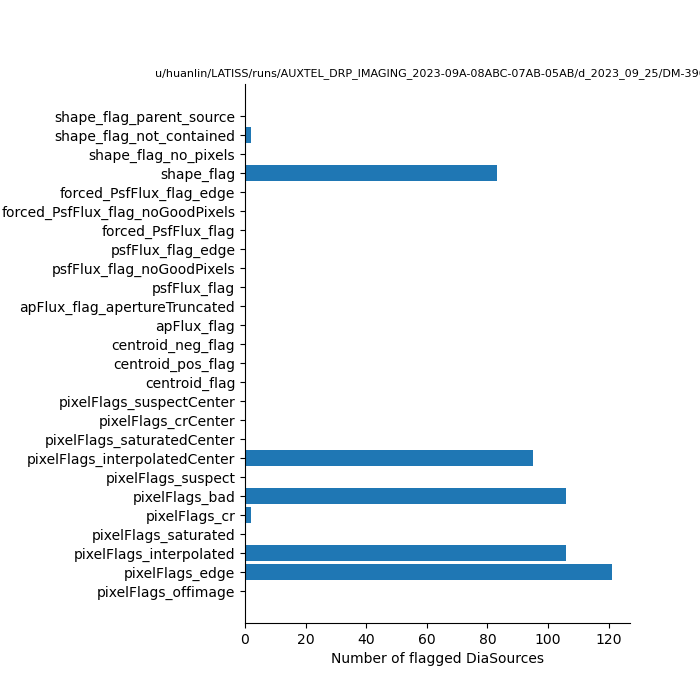

In [34]:
oneFlagTable = oneDiaSourceTableBig[flagList]
oneFlagLabels = oneFlagTable.columns
oneFlagSum = oneFlagTable.sum()
oneFlagsToPlot = [count for count in oneFlagSum.values]

fig, ax = plt.subplots(figsize=(7, 7))
ax.barh(oneFlagLabels, oneFlagsToPlot)#, color=flagColors)
fig.subplots_adjust(left=0.35)
ax.set_xlabel('Number of flagged DiaSources')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title(collectionBig, fontsize=8)

We are seeing the same 5 flags set for a significant number of DiaSources in both the older 05B and newer "Big" (05AB through 09A) collections. Let's plot one DiaSourceTable from each collection and see where those flagged sources are located spatially.

In [35]:
def spatial_flag_plot(df, flagName1, flagName2=None, operator=None, plotFlagged=True, plotUnFlagged=True, title=''):
    if flagName2 and operator:
        if operator == 'or':
            flagFilter = ((df[flagName1]) | (df[flagName2]))
            labelTrue = flagName1 + ' \nor ' + flagName2
            labelFalse = 'Neither ' + flagName1 + ' \nnor ' + flagName2
        elif operator == 'and':
            flagFilter = ((df[flagName1]) & (df[flagName2]))
            labelTrue = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse = 'Not ' + flagName1 + ' \nand ' + flagName2
        else:
            raise ValueError('Operator must be \'and\' or \n \'or\'')
    elif flagName2 and not operator:
        raise ValueError('Operator must be set if a second flag is given')
    else:  # just considering one flag
        flagFilter = (df[flagName1])
        labelTrue = flagName1
        labelFalse = 'No ' + flagName1
    flagFilterInverse = ~flagFilter
    
    fig, ax = plt.subplots()
    # Deal with schema changes
    if 'filterName' in df.columns:
        filterColumnName = 'filterName'
    else:
        filterColumnName = 'band'
    if 'decl' in df.columns:
        decColumnName = 'decl'
    else:
        decColumnName = 'dec'
    
    if plotFlagged:
        scatterFlagged = ax.scatter(df.loc[flagFilter, 'ra'], df.loc[flagFilter, decColumnName], 
                    color='C3', s=10, alpha=0.5, label=labelTrue)
    if plotUnFlagged:
        scatterUnflagged = ax.scatter(df.loc[flagFilterInverse, 'ra'], df.loc[flagFilterInverse, decColumnName], 
                    color='C0', s=10, alpha=0.5, label=labelFalse)
    print('Flagged sources: {0}'.format(len(df.loc[flagFilter, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df.loc[flagFilterInverse, 'ra'])))
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.title(title)

Flagged sources: 105
Unflagged sources: 51
Flagged sources: 100
Unflagged sources: 56
Flagged sources: 107
Unflagged sources: 49
Flagged sources: 108
Unflagged sources: 48
Flagged sources: 107
Unflagged sources: 49


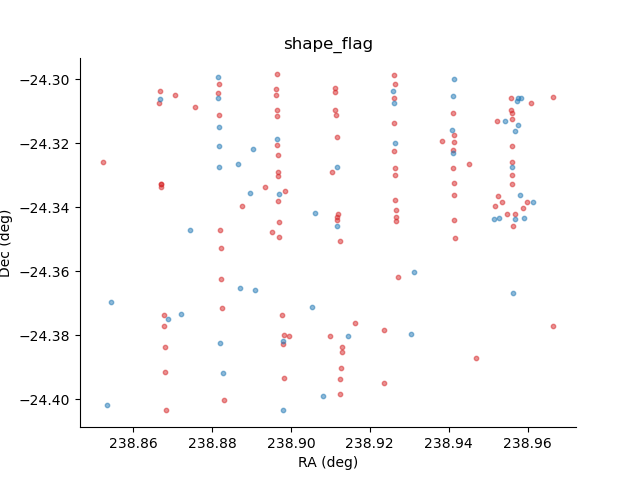

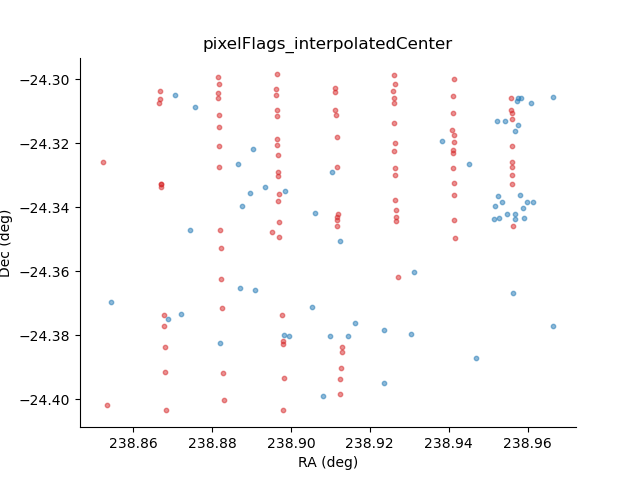

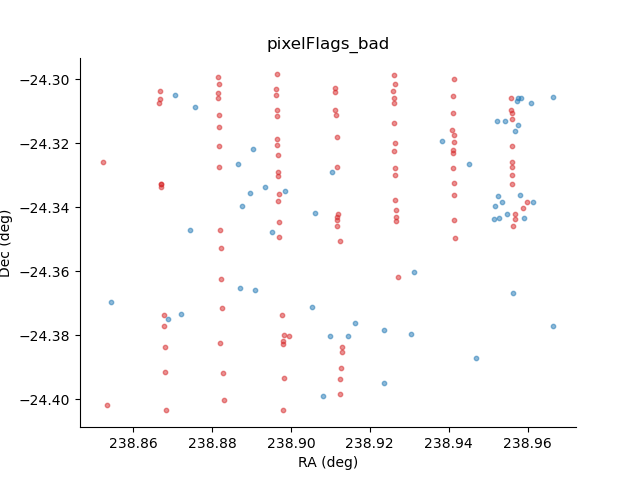

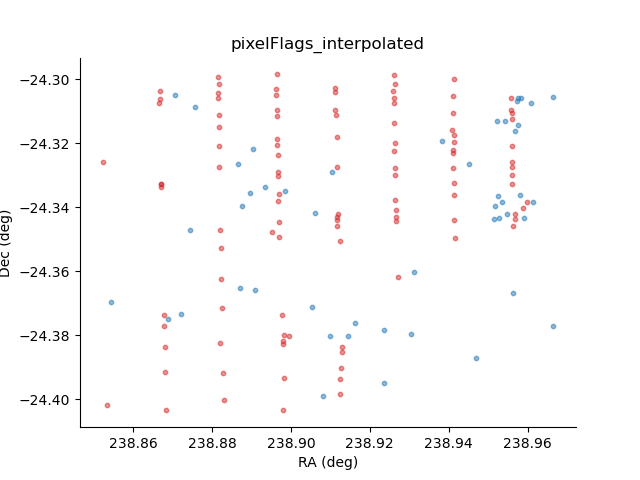

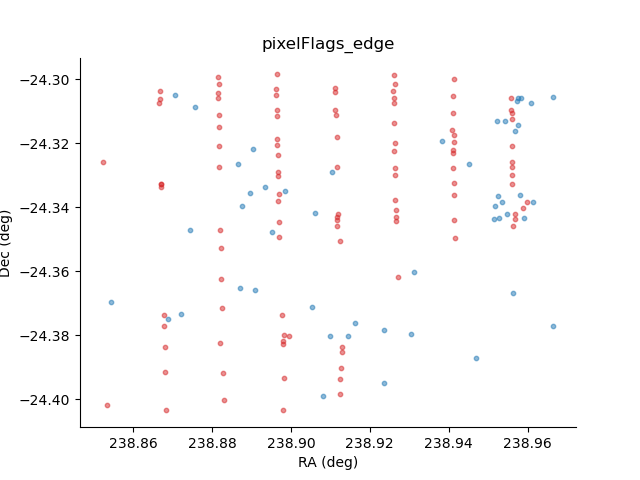

In [71]:
for flag in ['shape_flag', 'pixelFlags_interpolatedCenter', 'pixelFlags_bad', 'pixelFlags_interpolated', 'pixelFlags_edge']:
    spatial_flag_plot(oneDiaSourceTable05B, flag, title=flag)

Flagged sources: 83
Unflagged sources: 73
Flagged sources: 106
Unflagged sources: 50
Flagged sources: 95
Unflagged sources: 61
Flagged sources: 106
Unflagged sources: 50
Flagged sources: 121
Unflagged sources: 35


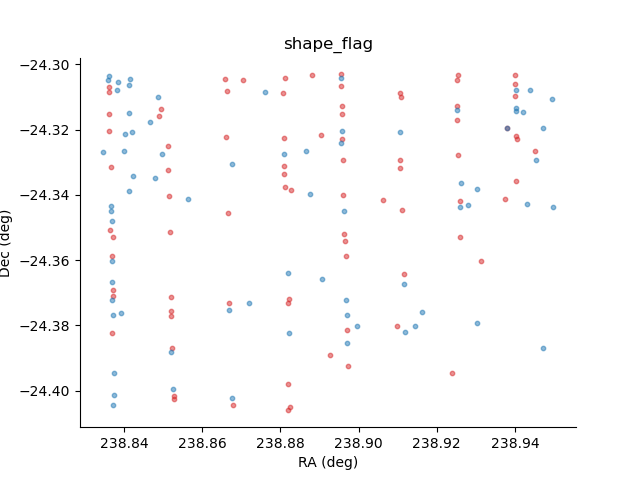

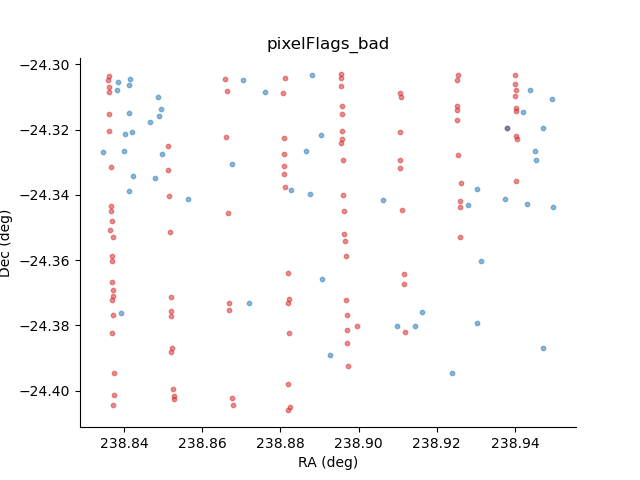

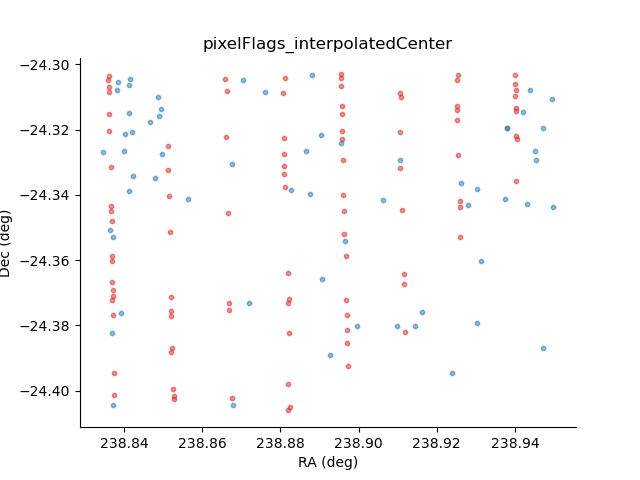

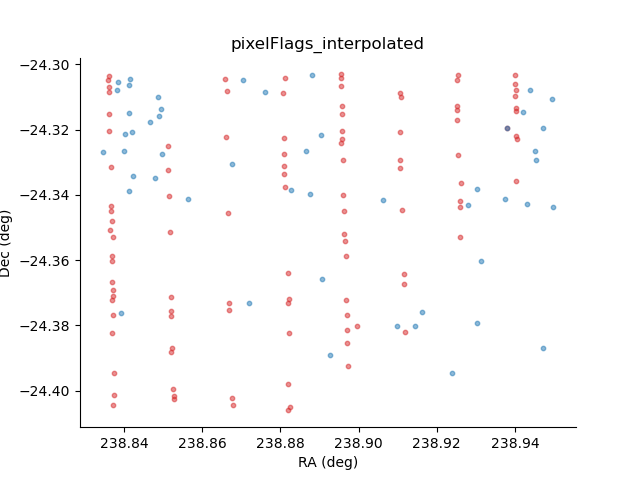

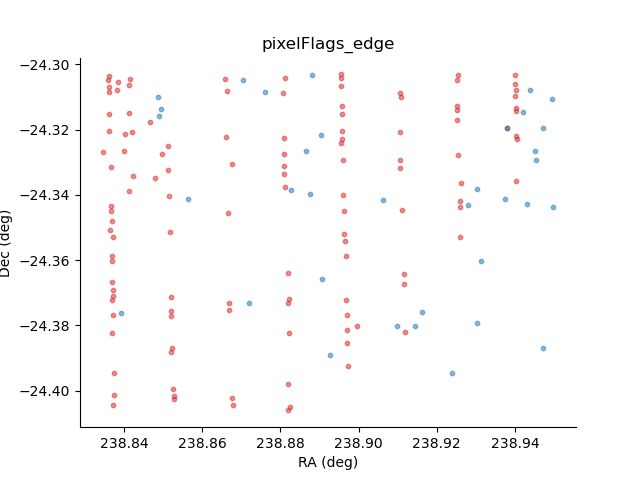

In [72]:
for flag in ['shape_flag', 'pixelFlags_bad', 'pixelFlags_interpolatedCenter', 'pixelFlags_interpolated', 'pixelFlags_edge']:
    spatial_flag_plot(oneDiaSourceTableBig, flag, title=flag)

## 4. <a id="section_4">Filter out flagged DiaSources</a>

Most of the clearly bad diaSources have all (bad, edge, interpolated, interpolatedCenter, shape) flags set. Let's filter out any source with one or more of these flags, since they are almost entirely appearing in the linear stripes of sadness, and try remaking our plots from earlier.

At this point, I went back up to the definition of `multiVisitPlotter` and added an argument to take a `badFlagList`.

In [73]:
badFlagList = ['shape_flag', 'pixelFlags_bad', 'pixelFlags_interpolatedCenter', 'pixelFlags_interpolated', 'pixelFlags_edge']

In [111]:
# Learning how to chain together pandas filters with | the fun way
conditionList = [oneDiaSourceTableBig[badFlag]==False for badFlag in badFlagList]
conditionOr = conditionList[0]
for condition in conditionList:
    conditionOr |= condition
conditionOr.name = 'bitwise_or_bad_flags'
print(conditionOr.value_counts())

bitwise_or_bad_flags
True     93
False    63
Name: count, dtype: int64


Visit 2023051100540: Ignoring 77 bad DiaSources (79 DiaSources remain)
Visit 2023052300628: Ignoring 53 bad DiaSources (165 DiaSources remain)
Visit 2023051100401: Ignoring 73 bad DiaSources (135 DiaSources remain)
Visit 2023051100535: Ignoring 79 bad DiaSources (108 DiaSources remain)
Visit 2023051100527: Ignoring 41 bad DiaSources (63 DiaSources remain)
Visit 2023051100341: Ignoring 39 bad DiaSources (197 DiaSources remain)
Visit 2023051100512: Ignoring 61 bad DiaSources (94 DiaSources remain)
Visit 2023051100511: Ignoring 68 bad DiaSources (74 DiaSources remain)
Visit 2023051100501: Ignoring 67 bad DiaSources (86 DiaSources remain)
Visit 2023052400673: Ignoring 37 bad DiaSources (193 DiaSources remain)
Visit 2023051100433: Ignoring 43 bad DiaSources (123 DiaSources remain)
Visit 2023051100279: Ignoring 56 bad DiaSources (115 DiaSources remain)
Visit 2023051100520: Ignoring 92 bad DiaSources (112 DiaSources remain)
Visit 2023052300615: Ignoring 55 bad DiaSources (271 DiaSources remai

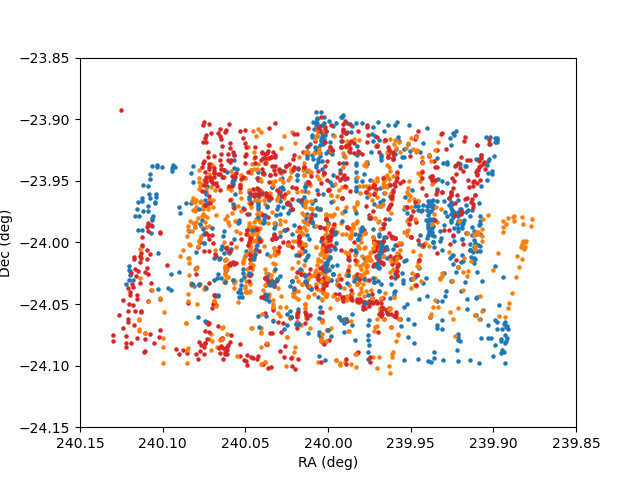

In [117]:
plt.figure()
ax = plt.gca()
ax.set_xlim(240.15, 239.85)
ax.set_ylim(-24.15, -23.85)
multiVisitPlotter(butler05B, visitList05B[0:30], badFlagList=badFlagList, printBadDiaSourceInfo=True)

Visit 2023051100306: Ignoring 41 bad DiaSources (87 DiaSources remain)
Visit 2023081700546: Ignoring 78 bad DiaSources (100 DiaSources remain)
Visit 2023082900412: Ignoring 65 bad DiaSources (147 DiaSources remain)
Visit 2023081600314: Ignoring 56 bad DiaSources (246 DiaSources remain)
Visit 2023070600524: Ignoring 39 bad DiaSources (196 DiaSources remain)
Visit 2023070500343: Ignoring 68 bad DiaSources (188 DiaSources remain)
Visit 2023070600519: Ignoring 100 bad DiaSources (115 DiaSources remain)
Visit 2023080300663: Ignoring 82 bad DiaSources (205 DiaSources remain)
Visit 2023072000181: Ignoring 77 bad DiaSources (201 DiaSources remain)
Visit 2023051100382: Ignoring 72 bad DiaSources (245 DiaSources remain)
Visit 2023071800262: Ignoring 94 bad DiaSources (148 DiaSources remain)
Visit 2023070600477: Ignoring 50 bad DiaSources (98 DiaSources remain)
Visit 2023072000185: Ignoring 94 bad DiaSources (127 DiaSources remain)
Visit 2023070600349: Ignoring 55 bad DiaSources (102 DiaSources r

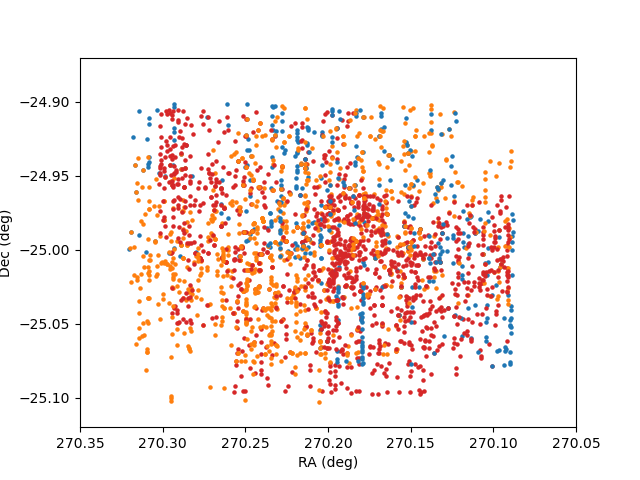

In [118]:
plt.figure()
ax = plt.gca()  # manually look at a region of the sky with a handful of visits
ax.set_xlim(270.35, 270.05)
ax.set_ylim(-25.12, -24.87)
multiVisitPlotter(butlerBig, visitListBig[1550:1580], badFlagList=badFlagList, printBadDiaSourceInfo=True)

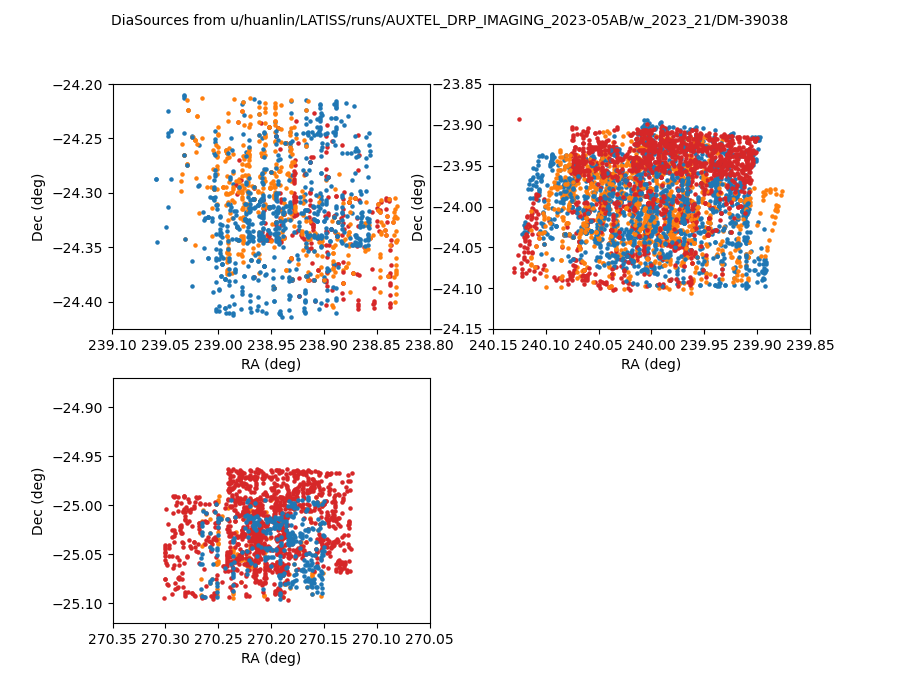

In [119]:
plotThreeSpatialRegions(butler05B, collection05B, visitList05B[0:50], badFlagList=badFlagList)

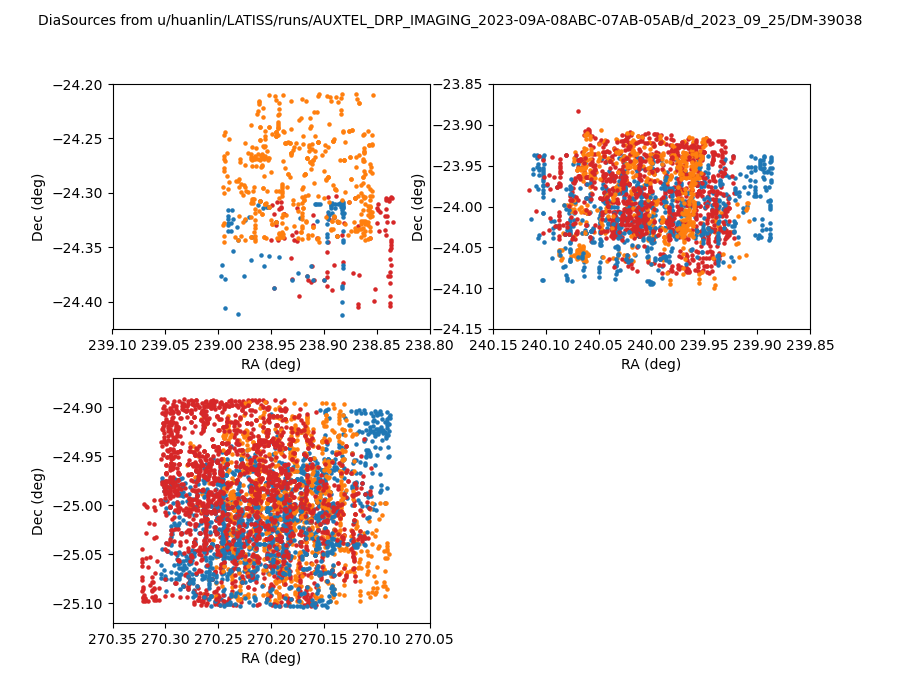

In [120]:
plotThreeSpatialRegions(butlerBig, collectionBig, visitListBig[0:50], badFlagList=badFlagList)